<a href="https://colab.research.google.com/github/cuboid0223/Deep-Generative-Models/blob/main/LSTM_Temperature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip


--2023-09-26 08:39:44--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.182.70.0, 52.217.174.168, 52.217.111.46, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.182.70.0|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  50.1MB/s    in 0.3s    

2023-09-26 08:39:45 (50.1 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [ ]:
import os

In [ ]:
data_dir='/content'
fname=os.path.join(data_dir,'jena_climate_2009_2016.csv')

In [ ]:
f=open(fname)
data=f.read()
f.close()

lines=data.split('\n')
header=lines[0].split(',')
lines=lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [ ]:
import numpy as np
float_data=np.zeros((len(lines),len(header)-1))
for i , line in enumerate(lines):
  values=[float(x) for x in line.split(',')[1:]]
  float_data[i,:]=values
print(float_data.shape)

(420451, 14)


In [ ]:
from matplotlib import pyplot as plt

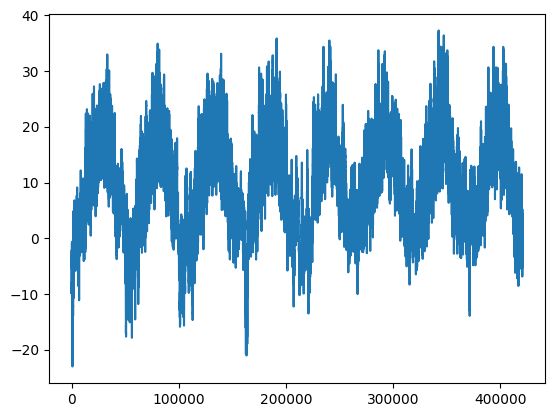

In [ ]:
temp = float_data[:,1]
plt.plot(range(len(temp)),temp)

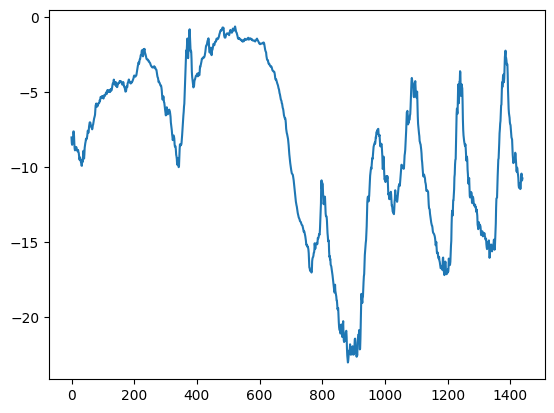

In [ ]:
plt.plot(range(1440),temp[:1440])

In [ ]:
lookback=5

In [ ]:
step=6
delay=144

In [ ]:
mean = float_data[:200000].mean(axis=0)
float_data-=mean
std=float_data[:200000].std(axis=0)
float_data/=std

In [ ]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)

        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [ ]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data, lookback=lookback, delay=delay, min_index=0, max_index=200000, shuffle=True, step=step, batch_size=batch_size)
val_gen = generator(float_data, lookback=lookback, delay=delay, min_index=20001, max_index=300000, step=step, batch_size=batch_size)
test_gen = generator(float_data, lookback=lookback, delay=delay, min_index=30001, max_index=None, step=step, batch_size=batch_size)
val_steps = (300000 - 200001 - lookback)//batch_size
test_steps = (len(float_data) - 300001 - lookback)//batch_size



In [ ]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print("Validation MAE:", np.mean(batch_maes))

evaluate_naive_method()

Validation MAE: 0.3131804213855729


In [ ]:
import numpy as np
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop

In [ ]:
model = Sequential()
model.add(LSTM(32, input_shape=(None, float_data.shape[-1])))
model.add(Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

In [ ]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20


<ipython-input-40-4f77649be1a6>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


500/500 [==============================] - 109s 213ms/step - loss: 0.2991 - val_loss: 0.2791
Epoch 2/20
500/500 [==============================] - 106s 212ms/step - loss: 0.2738 - val_loss: 0.2704
Epoch 3/20
500/500 [==============================] - 108s 217ms/step - loss: 0.2655 - val_loss: 0.2529
Epoch 4/20
500/500 [==============================] - 105s 211ms/step - loss: 0.2542 - val_loss: 0.2690
Epoch 5/20
500/500 [==============================] - 105s 210ms/step - loss: 0.2479 - val_loss: 0.2629
Epoch 6/20
500/500 [==============================] - 107s 213ms/step - loss: 0.2410 - val_loss: 0.2370
Epoch 7/20
500/500 [==============================] - 104s 208ms/step - loss: 0.2331 - val_loss: 0.2683
Epoch 8/20
500/500 [==============================] - 104s 209ms/step - loss: 0.2257 - val_loss: 0.2519
Epoch 9/20
500/500 [==============================] - 106s 212ms/step - loss: 0.2203 - val_loss: 0.2190
Epoch 10/20
500/500 [==============================] - 104s 208ms/step - lo

In [ ]:
mae = model.evaluate_generator(test_gen, steps=test_steps)
print("Test MAE:", mae)

<ipython-input-41-d159bb206be2>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  mae = model.evaluate_generator(test_gen, steps=test_steps)


Test MAE: 0.17701712250709534


In [ ]:
# 从测试数据生成器中获取一批数据
samples, targets = next(test_gen)
predictions = model.predict(samples)

# 反标准化预测值，以获得实际温度值
predictions = predictions * std[1] + mean[1]

4/4 [==============================] - 1s 27ms/step


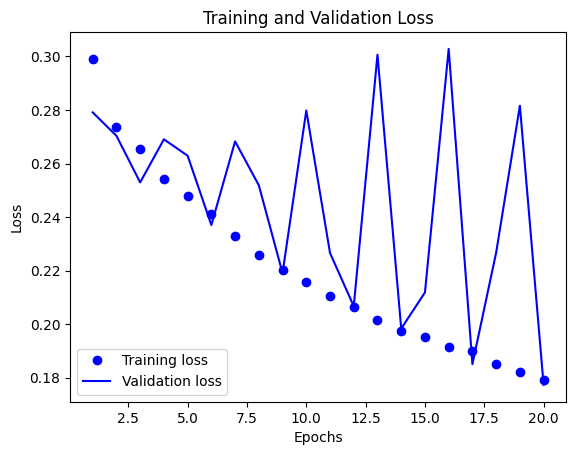

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

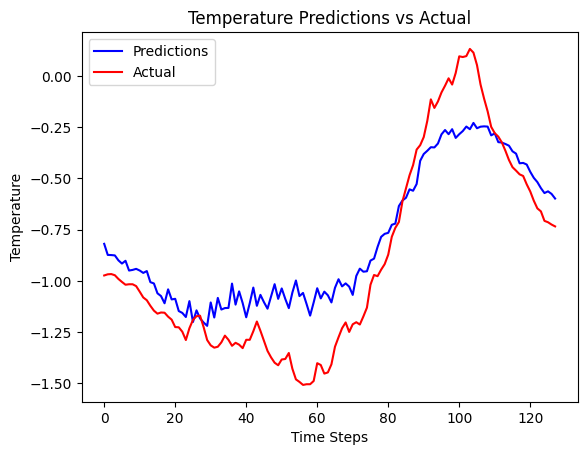

In [ ]:
plt.figure()
plt.plot(range(len(predictions)), predictions, 'b', label='Predictions')
plt.plot(range(len(targets)), targets, 'r', label='Actual')
plt.title('Temperature Predictions vs Actual')
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.legend()
plt.show()